<a href="https://colab.research.google.com/github/jgalazka/ERCC_analysis/blob/main/Study%20Level%20Analysis/Single%20Study%20ERCC%20Notebook%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GeneLab Study Level ERCC Notebook
This notebook shows an example of how the ERCC spike-ins can be used to assess the power of comparisons within a single study.

In certain studies ERCC Mix 1 and Mix 2 are distributed so that all samples in Group 1 (e.g. Spaceflight) have Mix 1 and all samples in Group 2 (e.g. Ground Control). As certain transcripts in Mix 1 and Mix 2 are present at a known ratio, we can determine how well these patterns are revealed in the dataset.

## Section 1: Setting up the Python environment

In [1]:
# import python packages
import pandas as pd
import numpy as np
from urllib.request import urlopen, quote, urlretrieve
from json import loads
from re import search
import zipfile
import seaborn as sns
from scipy.stats import linregress
import matplotlib.pyplot as plt

In [2]:
# Function to pull metadata zip from GeneLab
# Credit to Kirill Grigorev
GENELAB_ROOT = "https://genelab-data.ndc.nasa.gov"
GLDS_URL_PREFIX = GENELAB_ROOT + "/genelab/data/study/data/"
FILELISTINGS_URL_PREFIX = GENELAB_ROOT + "/genelab/data/study/filelistings/"
ISA_ZIP_REGEX = r'.*_metadata_.*[_-]ISA\.zip$'

def read_json(url):
    with urlopen(url) as response:
        return loads(response.read().decode())

def get_isa(accession):
    glds_json = read_json(GLDS_URL_PREFIX + accession)
    try:
        _id = glds_json[0]["_id"]
    except (AssertionError, TypeError, KeyError, IndexError):
        raise ValueError("Malformed JSON?")
    isa_entries = [
        entry for entry in read_json(FILELISTINGS_URL_PREFIX + _id)
        if search(ISA_ZIP_REGEX, entry["file_name"])
    ]
    if len(isa_entries) == 0:
        raise ValueError("Unexpected: no ISAs found")
    elif len(isa_entries) > 1:
        raise ValueError("Unexpected: multiple files match the ISA regex")
    else:
        entry = isa_entries[0]
        version = entry["version"]
        url = GENELAB_ROOT + entry["remote_url"] + "?version={}".format(version)
        alt_url = (
            GENELAB_ROOT + "/genelab/static/media/dataset/" +
            quote(entry["file_name"]) + "?version={}".format(version)
        )
        return entry["file_name"], version, url, alt_url

In [3]:
# Function to pull unnormalized counts from GeneLab
# Credit to Kirill Grigorev

RAW_COUNTS_REGEX = r'.*_rna_seq_Unnormalized_Counts.csv'

def get_rawcounts(accession):
    glds_json = read_json(GLDS_URL_PREFIX + accession)
    try:
        _id = glds_json[0]["_id"]
    except (AssertionError, TypeError, KeyError, IndexError):
        raise ValueError("Malformed JSON?")
    raw_counts_entries = [
        entry for entry in read_json(FILELISTINGS_URL_PREFIX + _id)
        if search(RAW_COUNTS_REGEX, entry["file_name"])
    ]
    if len(raw_counts_entries) == 0:
        raise ValueError("Unexpected: no Raw Counts found")
    elif len(raw_counts_entries) > 1:
        raise ValueError("Unexpected: multiple files match the Raw Counts regex")
    else:
        entry = raw_counts_entries[0]
        version = entry["version"]
        url = GENELAB_ROOT + entry["remote_url"] + "?version={}".format(version)
        alt_url = (
            GENELAB_ROOT + "/genelab/static/media/dataset/" +
            quote(entry["file_name"]) + "?version={}".format(version)
        )
        return entry["file_name"], version, url, alt_url

## Section 2: Get data and metadata

In [4]:
accession = 'GLDS-246' # Change this as necessary
isaurl = get_isa(accession)[3]
filehandle, _ = urlretrieve(isaurl)
zip_file_object = zipfile.ZipFile(filehandle, 'r')
zip_file_object.namelist() # Print contents of zip file. Pick relevant one from list

['.DS_Store',
 's_RR6_SPL.txt',
 'a_rr6_spl_transcription_profiling_RNA_Sequencing_(RNA-Seq).txt',
 'i_Investigation.txt']

In [5]:
sample_file = zip_file_object.namelist()[1]
file = zip_file_object.open(sample_file)
sample_table = pd.read_csv(zip_file_object.open(sample_file), sep='\t')

assay_file = zip_file_object.namelist()[2]
file = zip_file_object.open(assay_file)
assay_table = pd.read_csv(zip_file_object.open(assay_file), sep='\t')

In [6]:
raw_counts_file = get_rawcounts('GLDS-246')[3]
raw_counts_table = pd.read_csv(raw_counts_file, index_col=0)
raw_counts_table.index.rename('Gene_ID', inplace=True)

In [7]:
# Get ERCC counts
ercc_counts = raw_counts_table[raw_counts_table.index.str.contains('^ERCC-')]
ercc_counts.columns = ercc_counts.columns.str.replace('-','_')
ercc_counts.head(n=3)

,Mmus_C57_6T_SPL_BSL_LAR_Rep1_B3,Mmus_C57_6T_SPL_BSL_LAR_Rep2_B4,Mmus_C57_6T_SPL_BSL_LAR_Rep3_B5,Mmus_C57_6T_SPL_BSL_LAR_Rep4_B6,Mmus_C57_6T_SPL_BSL_LAR_Rep5_B7,Mmus_C57_6T_SPL_BSL_LAR_Rep6_B8,Mmus_C57_6T_SPL_BSL_LAR_Rep7_B9,Mmus_C57_6T_SPL_BSL_LAR_Rep8_B10,Mmus_C57_6T_SPL_BSL_LAR_Rep9_B1,Mmus_C57_6T_SPL_BSL_LAR_Rep10_B2,Mmus_C57_6T_SPL_GC_LAR_Rep1_G3,Mmus_C57_6T_SPL_GC_LAR_Rep2_G4,Mmus_C57_6T_SPL_GC_LAR_Rep3_G5,Mmus_C57_6T_SPL_GC_LAR_Rep4_G6,Mmus_C57_6T_SPL_GC_LAR_Rep5_G7,Mmus_C57_6T_SPL_GC_LAR_Rep6_G8,Mmus_C57_6T_SPL_GC_LAR_Rep7_G9,Mmus_C57_6T_SPL_GC_LAR_Rep8_G10,Mmus_C57_6T_SPL_GC_LAR_Rep9_G2,Mmus_C57_6T_SPL_FLT_LAR_Rep1_F3,Mmus_C57_6T_SPL_FLT_LAR_Rep2_F4,Mmus_C57_6T_SPL_FLT_LAR_Rep3_F5,Mmus_C57_6T_SPL_FLT_LAR_Rep4_F6,Mmus_C57_6T_SPL_FLT_LAR_Rep5_F7,Mmus_C57_6T_SPL_FLT_LAR_Rep6_F8,Mmus_C57_6T_SPL_FLT_LAR_Rep7_F9,Mmus_C57_6T_SPL_FLT_LAR_Rep8_F10,Mmus_C57_6T_SPL_BSL_ISS_T_Rep1_B6,Mmus_C57_6T_SPL_BSL_ISS_T_Rep2_B7,Mmus_C57_6T_SPL_BSL_ISS_T_Rep3_B8,Mmus_C57_6T_SPL_GC_ISS_T_Rep1_G3,Mmus_C57_6T_SPL_GC_ISS_T_Rep2_G4,Mmus_C57_6T_SPL_GC_ISS_T_Rep3_G5,Mmus_C57_6T_SPL_GC_ISS_T_Rep4_G6,Mmus_C57_6T_SPL_GC_ISS_T_Rep5_G8,Mmus_C57_6T_SPL_GC_ISS_T_Rep6_G9,Mmus_C57_6T_SPL_GC_ISS_T_Rep7_G10,Mmus_C57_6T_SPL_FLT_ISS_T_Rep1_F3,Mmus_C57_6T_SPL_FLT_ISS_T_Rep2_F4,Mmus_C57_6T_SPL_FLT_ISS_T_Rep3_F5,Mmus_C57_6T_SPL_FLT_ISS_T_Rep4_F7,Mmus_C57_6T_SPL_FLT_ISS_T_Rep5_F8,Mmus_C57_6T_SPL_FLT_ISS_T_Rep6_F9,Mmus_C57_6T_SPL_FLT_ISS_T_Rep7_F10
Gene_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ERCC-00002,769.0,533.0,1888.0,456.0,212.0,163.0,735.0,17.0,211.0,240.0,1244.0,1102.0,102.0,621.0,1209.0,1245.0,213.0,327.0,412.0,809.0,2688.0,367.0,4336.0,731.0,2421.0,430.0,396.0,1800.0,3571.0,832.0,3009.0,2708.0,6732.0,3034.0,4129.0,487.0,784.0,1615.0,1737.0,1842.0,1713.0,323.0,329.0,319.0
ERCC-00003,44.0,30.0,140.0,18.0,10.0,9.0,29.0,10.0,10.0,15.0,58.0,61.0,9.0,28.0,79.0,78.0,12.0,24.0,27.0,24.0,126.0,26.0,223.0,31.0,121.0,22.0,28.0,105.0,264.0,38.0,150.0,139.0,376.0,188.0,164.0,36.0,47.0,100.0,98.0,102.0,67.0,12.0,20.0,23.0
ERCC-00004,215.0,111.0,606.0,97.0,94.0,138.0,227.0,67.0,51.0,82.0,279.0,316.0,90.0,148.0,371.0,347.0,49.0,105.0,145.0,15.0,98.0,27.0,150.0,23.0,102.0,15.0,11.0,83.0,173.0,28.0,75.0,70.0,234.0,83.0,143.0,26.0,29.0,539.0,512.0,545.0,443.0,142.0,76.0,137.0


In [8]:
# Get ERCC files
ercc_url = 'https://assets.thermofisher.com/TFS-Assets/LSG/manuals/cms_095046.txt'
filehandle, _ = urlretrieve(ercc_url)
ercc_table = pd.read_csv(filehandle, '\t')
#ercc_table.head(n=3)

In [9]:
combined = sample_table.merge(assay_table, on='Sample Name')
combined = combined.set_index(combined['Sample Name'])
#combined.head(n=3)

In [10]:
flightground = combined['Factor Value[Spaceflight]'].isin(['Space Flight', 'Ground Control'])
lar = combined['Factor Value[Euthanasia]'] == 'On Earth'

In [11]:
fewsamples = combined[flightground].loc[:,['Factor Value[Spaceflight]','Parameter Value[Spike-in Mix number]']]
fewsamples.index = fewsamples.index.str.replace('-','_')

In [12]:
fewsamples.columns = ['Spaceflight','Mix']
fewsamples.to_csv('fewsamples.csv')

In [13]:
fewcounts = ercc_counts.loc[:,fewsamples.index]

In [14]:
fewcounts.to_csv('fewcounts.csv')

## Section 3: Perform DESeq2 analysis of ERCC counts

In [15]:
%load_ext rpy2.ipython

/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [17]:
%%R
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("DESeq2")

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/BiocManager_1.30.10.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 40205 bytes (39 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[

In [18]:
%%R
library("DESeq2")

R[write to console]: Loading required package: S4Vectors

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, 

In [19]:
%%R
cts <- as.matrix(read.csv('fewcounts.csv',sep=",",row.names="Gene_ID"))
coldata <- read.csv('fewsamples.csv', row.names=1)

In [20]:
%%R
coldata$Spacefligth <- factor(coldata$Spaceflight)
coldata$Mix <- factor(coldata$Mix)

In [21]:
%%R
all(rownames(coldata) == colnames(cts))

[1] TRUE


In [22]:
%%R
dds <- DESeqDataSetFromMatrix(countData = cts,
                              colData = coldata,
                              design = ~ Mix)
dds

R[write to console]: converting counts to integer mode

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



class: DESeqDataSet 
dim: 92 31 
metadata(1): version
assays(1): counts
rownames(92): ERCC-00002 ERCC-00003 ... ERCC-00170 ERCC-00171
rowData names(0):
colnames(31): Mmus_C57_6T_SPL_GC_LAR_Rep1_G3
  Mmus_C57_6T_SPL_GC_LAR_Rep2_G4 ... Mmus_C57_6T_SPL_FLT_ISS_T_Rep6_F9
  Mmus_C57_6T_SPL_FLT_ISS_T_Rep7_F10
colData names(3): Spaceflight Mix Spacefligth


In [23]:
%%R
dds <- DESeq(dds)
res <- results(dds, contrast=c("Mix","Mix 1","Mix 2"))
res

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: final dispersion estimates

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '

log2 fold change (MLE): Mix Mix 1 vs Mix 2 
Wald test p-value: Mix Mix 1 vs Mix 2 
DataFrame with 92 rows and 6 columns
              baseMean log2FoldChange     lfcSE       stat      pvalue
             <numeric>      <numeric> <numeric>  <numeric>   <numeric>
ERCC-00002 983.6734195     -0.8170713 0.0710113 -11.506213 1.22751e-30
ERCC-00003  53.7784837     -0.7062567 0.0927793  -7.612219 2.69430e-14
ERCC-00004 141.1612233      2.3701598 0.1183471  20.027184 3.19205e-89
ERCC-00009  26.6929722      0.0932392 0.1309742   0.711890 4.76533e-01
ERCC-00012   0.0156534      0.4599879 2.9764259   0.154544 8.77181e-01
...                ...            ...       ...        ...         ...
ERCC-00164  0.00928802       0.086452 2.9759089  0.0290506  0.97682423
ERCC-00165  2.59453099      -1.415248 0.3696268 -3.8288565  0.00012874
ERCC-00168  0.00000000             NA        NA         NA          NA
ERCC-00170  1.24766698       1.840440 0.5567074  3.3059381  0.00094659
ERCC-00171 98.46496320      

In [24]:
%%R
write.csv(res, 'ERCC_DESeq2.csv')

In [25]:
%%R
normcounts = counts(dds, normalized=TRUE)
write.csv(normcounts, 'ERCC_normcounts.csv')

## Section 4: Analyze DESeq2 results

In [26]:
deseq2out = pd.read_csv('ERCC_DESeq2.csv', index_col=0)
#deseq2out.index = deseq2out.index.str.replace('_','-')
deseq2out.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ERCC-00002,983.673419,-0.817071,0.071011,-11.506213,1.227508e-30,1.432092e-29
ERCC-00003,53.778484,-0.706257,0.092779,-7.612219,2.694296e-14,2.095564e-13
ERCC-00004,141.161223,2.370160,0.118347,20.027184,3.192055e-89,7.448128e-88
ERCC-00009,26.692972,0.093239,0.130974,0.711890,4.765332e-01,8.553160e-01
ERCC-00012,0.015653,0.459988,2.976426,0.154544,8.771810e-01,9.979669e-01


In [27]:
# Get ERCC files
ercc_url = 'https://assets.thermofisher.com/TFS-Assets/LSG/manuals/cms_095046.txt'
filehandle, _ = urlretrieve(ercc_url)
ercc_table = pd.read_csv(filehandle, '\t', index_col='ERCC ID')
ercc_table.head(n=3)

,Re-sort ID,subgroup,concentration in Mix 1 (attomoles/ul),concentration in Mix 2 (attomoles/ul),expected fold-change ratio,log2(Mix 1/Mix 2)
ERCC ID,,,,,,
ERCC-00130,1,A,30000.0,7500.00,4.0,2.0
ERCC-00004,2,A,7500.0,1875.00,4.0,2.0
ERCC-00136,3,A,1875.0,468.75,4.0,2.0


In [28]:
combined = deseq2out.merge(ercc_table, left_index=True, right_index=True)
combined.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Re-sort ID,subgroup,concentration in Mix 1 (attomoles/ul),concentration in Mix 2 (attomoles/ul),expected fold-change ratio,log2(Mix 1/Mix 2)
ERCC-00002,983.673419,-0.817071,0.071011,-11.506213,1.227508e-30,1.432092e-29,70,D,15000.000000,30000.000000,0.50,-1.00
ERCC-00003,53.778484,-0.706257,0.092779,-7.612219,2.694296e-14,2.095564e-13,72,D,937.500000,1875.000000,0.50,-1.00
ERCC-00004,141.161223,2.370160,0.118347,20.027184,3.192055e-89,7.448128e-88,2,A,7500.000000,1875.000000,4.00,2.00
ERCC-00009,26.692972,0.093239,0.130974,0.711890,4.765332e-01,8.553160e-01,26,B,937.500000,937.500000,1.00,0.00
ERCC-00012,0.015653,0.459988,2.976426,0.154544,8.771810e-01,9.979669e-01,67,C,0.114441,0.171661,0.67,-0.58


In [29]:
combined['cleanedpadj'] = combined['padj']
combined.loc[(combined.cleanedpadj < 0.00001),'cleanedpadj']=0.00001

combined['cleanedp'] = combined['pvalue']
combined.loc[(combined.cleanedp < 0.00001),'cleanedp']=0.00001

combined.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Re-sort ID,subgroup,concentration in Mix 1 (attomoles/ul),concentration in Mix 2 (attomoles/ul),expected fold-change ratio,log2(Mix 1/Mix 2),cleanedpadj,cleanedp
ERCC-00002,983.673419,-0.817071,0.071011,-11.506213,1.227508e-30,1.432092e-29,70,D,15000.000000,30000.000000,0.50,-1.00,0.000010,0.000010
ERCC-00003,53.778484,-0.706257,0.092779,-7.612219,2.694296e-14,2.095564e-13,72,D,937.500000,1875.000000,0.50,-1.00,0.000010,0.000010
ERCC-00004,141.161223,2.370160,0.118347,20.027184,3.192055e-89,7.448128e-88,2,A,7500.000000,1875.000000,4.00,2.00,0.000010,0.000010
ERCC-00009,26.692972,0.093239,0.130974,0.711890,4.765332e-01,8.553160e-01,26,B,937.500000,937.500000,1.00,0.00,0.855316,0.476533
ERCC-00012,0.015653,0.459988,2.976426,0.154544,8.771810e-01,9.979669e-01,67,C,0.114441,0.171661,0.67,-0.58,0.997967,0.877181


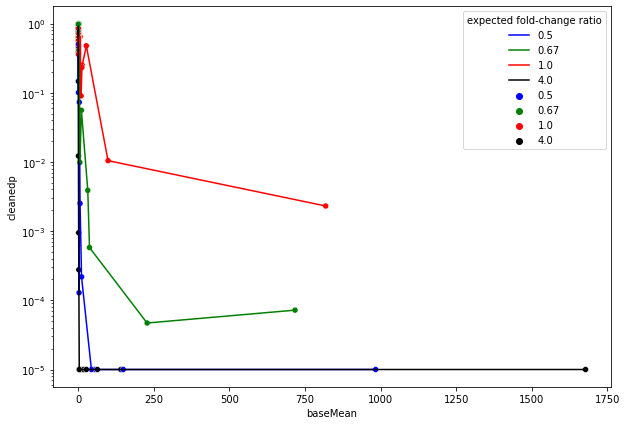

In [30]:
fig, ax = plt.subplots(figsize=(10, 7))

sns.scatterplot(data=combined, x="baseMean", y="cleanedp",
            hue="expected fold-change ratio",
                palette=['blue','green','red','black'], ax=ax)

sns.lineplot(data=combined, x="baseMean", y="cleanedp",
            hue="expected fold-change ratio",
                palette=['blue','green','red','black'], ax=ax)

#g.set_xscale("log", base=2)
ax.set_xscale("linear")
ax.set_yscale("log")